In [15]:
library(naturalsort)
library(data.table)
library(data.tree)
library(Biostrings)
library(fields)
dataDir <- '../../Data/SimOut1/'

Loading required package: spam
Loading required package: dotCall64
Loading required package: grid
Spam version 2.1-2 (2017-12-21) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.

Attaching package: ‘spam’

The following object is masked from ‘package:stats4’:

    mle

The following objects are masked from ‘package:base’:

    backsolve, forwardsolve

Loading required package: maps
See www.image.ucar.edu/~nychka/Fields for
 a vignette and other supplements. 


In [5]:
flst<-list.files(dataDir) # Get list of files from directory
flst <- naturalsort(flst) # Natural sort the files
ncls <- c()
rs <- c()
k<-1
for (i in 1:(length(flst))) {
    load(paste0(dataDir,flst[i]))
    if (CellPop$totalCount==1) {
        ncls[[k]] <- CellPop$ncells[length(CellPop$ncells)]
    }
    else {
        ncls[[k]] <- sum(vapply(CellPop$Get('ncells'),tail,n=1L,FUN.VALUE = numeric(1)))
    }
    rs[[k]] <- CellPop$Get('r')
    rm('CellPop')
    k <- k+1
    
}

In [6]:
rs_var <- c()
ncells_var <- c()

for (i in 1:length(rs)) {
    
    if (length(rs[[i]])==1) {rs_var[i] <- 0}
    else {rs_var[i] <- var(rs[[i]])}
    ncells_var[i] <- var(ncls[[i]])

}

In [7]:
norml <- function(x) {
    x = (x-min(x))/(max(x)-min(x))
    return(x)}

In [18]:
ncls

[1] 261719 257422 260216 258999 260759 260544 260958 261102 259481 260521
[11] 260065 260895 258648 260510 259841 258012 258504 259421 259679 260962
[21] 261222

In [9]:
matrix(ncls[1:20],nrow=4,ncol=5,byrow=TRUE)

261719,257422,260216,258999,260759
260544,260958,261102,259481,260521
260065,260895,258648,260510,259841
258012,258504,259421,259679,260962


In [10]:
matrix(rs_var[1:20],nrow=4,ncol=5,byrow=TRUE)

0.001117065,0.004368317,0.007490437,0.01307617,0.02025206
0.001698628,0.004685942,0.009939573,0.01375753,0.02087027
0.001807852,0.004608279,0.009108393,0.01434587,0.02022069
0.002838599,0.008083436,0.016810635,0.01604677,0.02627520


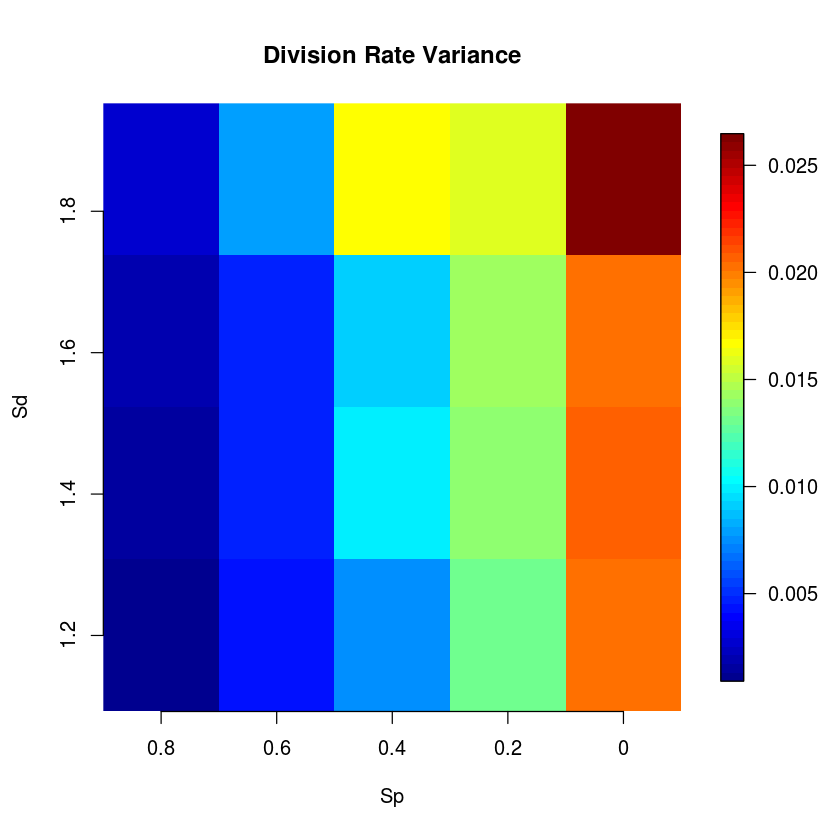

In [26]:
rotate <- function(x) t(apply(x, 2, rev))

image.plot(rotate(apply(matrix(rs_var[1:20],nrow=4,ncol=5,byrow=TRUE),2,rev)),axes=F)

title(main="Division Rate Variance",xlab='Sp',ylab='Sd');
axis(1, at=seq(0,1,0.25), labels=seq(0.8,0.0,-0.2)); 
axis(2, at=seq(0,1,0.31), labels=seq(1.2,1.8,0.2)); 


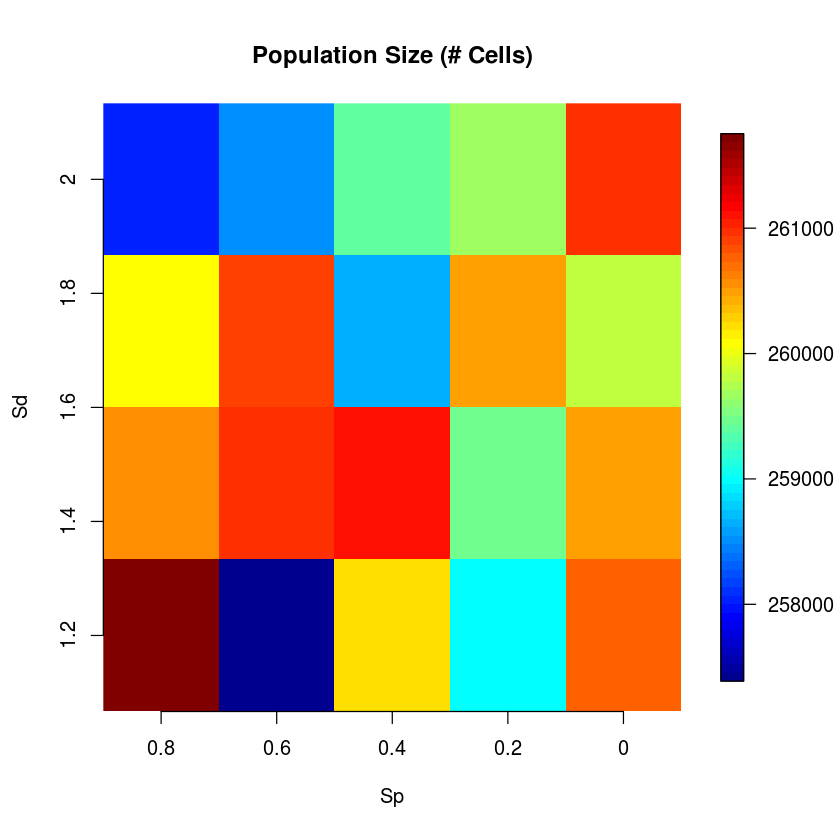

In [27]:
rotate <- function(x) t(apply(x, 2, rev))

image.plot(rotate(apply(matrix(ncls[1:20],nrow=4,ncol=5,byrow=TRUE),2,rev)),axes=F)

title(main="Population Size (# Cells)",xlab='Sp',ylab='Sd');
axis(1, at=seq(0,1,0.25), labels=seq(0.8,0.0,-0.2)); 
axis(2, at=seq(0,1,0.25), labels=seq(1.2,2.0,0.2)); 

In [ ]:
load('../../Data/SimOut1_2/0.rda')

In [ ]:
print(CellPop,'r')

In [ ]:
traversal <- Traverse(CellPop, traversal = "post-order", filterFun = function(x) x$r != 1)

In [ ]:
traversal[[1]]$tes

In [ ]:
# PURPOSE: Updates the gene annotation of the clone
#
# INPUT:
#   anno         (data frame) Annotation of genes (i.e. chromosome   start   end)
#   simout          (list of lists) gen_sim output
#   tes             (list of lists) Node tes
#
# OUTPUT: anno

update_anno <- function(anno,  tes) {
    
#     tmp = mapply(append, simout, tes, SIMPLIFY = FALSE)
    tmp=tes
    for (i in 1:length(tmp[[3]])) {
        # Shift the start loci of genes with start loci beyond the insertion by the width of the L1
        anno[anno$chrom==tmp[[2]][i] & anno$start>tmp[[3]][i],]$start <- anno[anno$chrom==tmp[[2]][i] & anno$start>tmp[[3]][i],]$start + width(tmp[[1]][i])  
        # Shift the end loci of genes with start loci beyond the insertion by the width of the L1
        anno[anno$chrom==tmp[[2]][i] & anno$start>tmp[[3]][i],]$end <- anno[anno$chrom==tmp[[2]][i] & anno$start>tmp[[3]][i],]$end + width(tmp[[1]][i])  
        # Shift the end locus of any gene with only end locus beyond the insertion by the width of the L1
        anno[anno$chrom==tmp[[2]][i] & anno$end>tmp[[3]][i] & anno$start<tmp[[3]][i],]$end <- anno[anno$chrom==tmp[[2]][i] & anno$end>tmp[[3]][i] & anno$start<tmp[[3]][i],]$end + width(tmp[[1]][i])        
    }
    return(anno) 
}

In [ ]:
rank_clone <- function(r, anno, sites_chrm, sites_loci, gainp, lossp) {

    gene_hits=0; # set counter to zero
    tsg_hits=0;
    for (i in 1:length(unique(sites_chrm))) { # loop over chromosomes inserted into
        tmp=anno[anno$chrom==unique(sites_chrm)[i],] # reduce annotation table to entries for current chrom
        chrmann_ntsg=tmp[tmp$istsg==0,]
        chrmann_tsg =tmp[tmp$istsg==1,]
        tmp = sites_loci[sites_chrm==unique(sites_chrm)[i]] # reduce insertion loci to entries for current chrom
        tmp_hits = between(tmp,chrmann_ntsg$start,chrmann_ntsg$end) # create logical for insertions, whether into non-tsg-gene or not
        gene_hits=gene_hits+length(which(tmp_hits==TRUE)) # count the number of non-tsg-gene insertions
#         print(gene_hits)
        tmp_hits  = between(tmp,chrmann_tsg$start,chrmann_tsg$end) # same for tsg-gene insertions
        tsg_hits =tsg_hits+length(which(tmp_hits==TRUE))
    }

    if (gene_hits > 0 || tsg_hits > 0){
        r=r*(lossp^gene_hits)*(gainp^tsg_hits)
    }

    if (r < 0.25) { # If the division rate is below 0.25, the clone stops growing
        r<-0
    }

    return(r)
}


In [ ]:
load('../../sim-develop/data/exann.rda')

In [ ]:
head(exann)

In [ ]:
k <- traversal[[1]]$tes

In [ ]:
k

In [ ]:
tmpAnn <- update_anno(exann,k)

In [ ]:
load('../../sim-develop/data/exann.rda')
for (node in traversal) {
    nodeTes <- node$tes
    tmpAnn <- update_anno(exann,nodeTes)
    
    
}

In [ ]:
r <- rank_clone(1,tmpAnn,k[[2]],k[[3]],1.2,.8)
r